In [1]:
!pip install git+https://github.com/Evan-Kim2028/DataStreams.git

  Cloning https://github.com/Evan-Kim2028/DataStreams.git to /tmp/pip-req-build-pqcmepmh
  Running command git clone --filter=blob:none --quiet https://github.com/Evan-Kim2028/DataStreams.git /tmp/pip-req-build-pqcmepmh
  Resolved https://github.com/Evan-Kim2028/DataStreams.git to commit 85a08d76e37d66df8896f91d9f8e1c5edf653608
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for DataStreams: filename=DataStreams-0.0.post1.dev48+g85a08d7-py3-none-any.whl size=7289 sha256=dddf301996717148f61cc5670adc29ddf2ac2045b8945a8dadac1a2a2f3a40e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-i6rsybtz/wheels/06/e7/63/91de055318e05be20cb8ce687f960fcb1ae3a9e77f754cda6c
Successfully built DataStreams
  Attempting uninstall: DataStreams
    Found existing installation: DataStreams 0.0.post1.dev47+g79b462e
    Uninstalling DataStreams-0.0.post1.dev47+g79b46

In [2]:
from datastreams.datastream import Streamer

import matplotlib.pyplot as plt
import pandas as pd

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [4]:
endpoint = 'https://api.thegraph.com/subgraphs/name/openpredict/chainlink-prices-subgraph'

In [5]:
# load streamer class
ds = Streamer(endpoint)

In [6]:
# check available query fields
ds.queryFields

[FieldPath(https://api.thegraph.com/subgraphs/name/openpredict/chainlink-prices-subgraph, Query, ['prices']),
 FieldPath(https://api.thegraph.com/subgraphs/name/openpredict/chainlink-prices-subgraph, Query, ['assetPairs'])]

### Bounded Historical Price Query

This example shows how to query the historical USD price of ETH from the chainlink pricefeed subgraph node. The query is bounded by a start and end time.

In [7]:
 # define an eth price filter 50,000 range where 1673750000 < timestamp < 1673800000
eth_bounded_filter = {'timestamp_lt': 1673800000, 'timestamp_gt': 1673750000, 'assetPair': "ETH/USD"}

In [8]:
eth_bounded_df = ds.runQuery(ds.queryDict.get('prices'), where=eth_bounded_filter, query_size=777)

FIELD - prices
Filter based on these values: {'timestamp_lt': 1673800000, 'timestamp_gt': 1673750000, 'assetPair': 'ETH/USD'}


In [9]:
# verify that the df returns valid data:
print(f'Number of rows: {eth_bounded_df.index.size}, first timestamp: {eth_bounded_df["prices_timestamp"].iloc[0]}, second timestamp: {eth_bounded_df["prices_timestamp"].iloc[-1]}')

Number of rows: 21, first timestamp: 1673799527, second timestamp: 1673751323


In [10]:
#print the difference between the first and last timestamp in f string
print(f'Timestamp range difference: {eth_bounded_df["prices_timestamp"].iloc[0] - eth_bounded_df["prices_timestamp"].iloc[-1]}')

Timestamp range difference: 48204


### Unbounded Price Query for multiple assets

This example shows how to query multiple USD prices  for ETH, BTC, LINK, and UNI. The query is unbounded by a start and end time.

In [11]:
keys = ['timestamp_lt', 'assetPair']
initial_vals = [1673800967, 'ETH/USD']

search_vals = ["ETH/USD", "BTC/USD", "LINK/USD", "UNI/USD"]

In [18]:
price_dfs_list = ds.runSameQuerySearch(
    fieldParam = ds.queryDict.get('prices'),
    keys = keys, 
    values = initial_vals,
    searchKey = keys[1],
    searchVals = search_vals,
    query_size = 101
    )

search_dict: {'timestamp_lt': 1673800967, 'assetPair': 'ETH/USD'}
val: ETH/USD
FIELD - prices
Filter based on these values: {'timestamp_lt': 1673800967, 'assetPair': 'ETH/USD'}
ETH/USD               prices_id prices_assetPair_id  prices_timestamp  prices_price
0    ETH/USD/0x63c42767             ETH/USD        1673799527  154719000000
1    ETH/USD/0x63c42203             ETH/USD        1673798147  155548527829
2    ETH/USD/0x63c42173             ETH/USD        1673798003  155732000000
3    ETH/USD/0x63c41f1b             ETH/USD        1673797403  154900870000
4    ETH/USD/0x63c413db             ETH/USD        1673794523  154057000000
..                  ...                 ...               ...           ...
96   ETH/USD/0x63c1f973             ETH/USD        1673656691  149483390000
97   ETH/USD/0x63c1f94f             ETH/USD        1673656655  148427859807
98   ETH/USD/0x63c1f67f             ETH/USD        1673655935  147557000000
99   ETH/USD/0x63c1f4f3             ETH/USD        1673

#### Plot ETH/USD price data

In [19]:
# this is the eth/usd price df
eth_df = price_dfs_list[0]

In [20]:
# convert prices_timestamp to datetime, convert prices_price to USD value.
eth_df['prices_timestamp'] = pd.to_datetime(eth_df['prices_timestamp'], unit='s')
# divide prices_price by 10^8 to get price in USD
eth_df['prices_price'] = eth_df['prices_price'] / 100000000

In [21]:
# check the recent timestamp in UTC
print(f'most recent timestamp of data: {eth_df["prices_timestamp"].iloc[0]}')

most recent timestamp of data: 2023-01-15 16:18:47


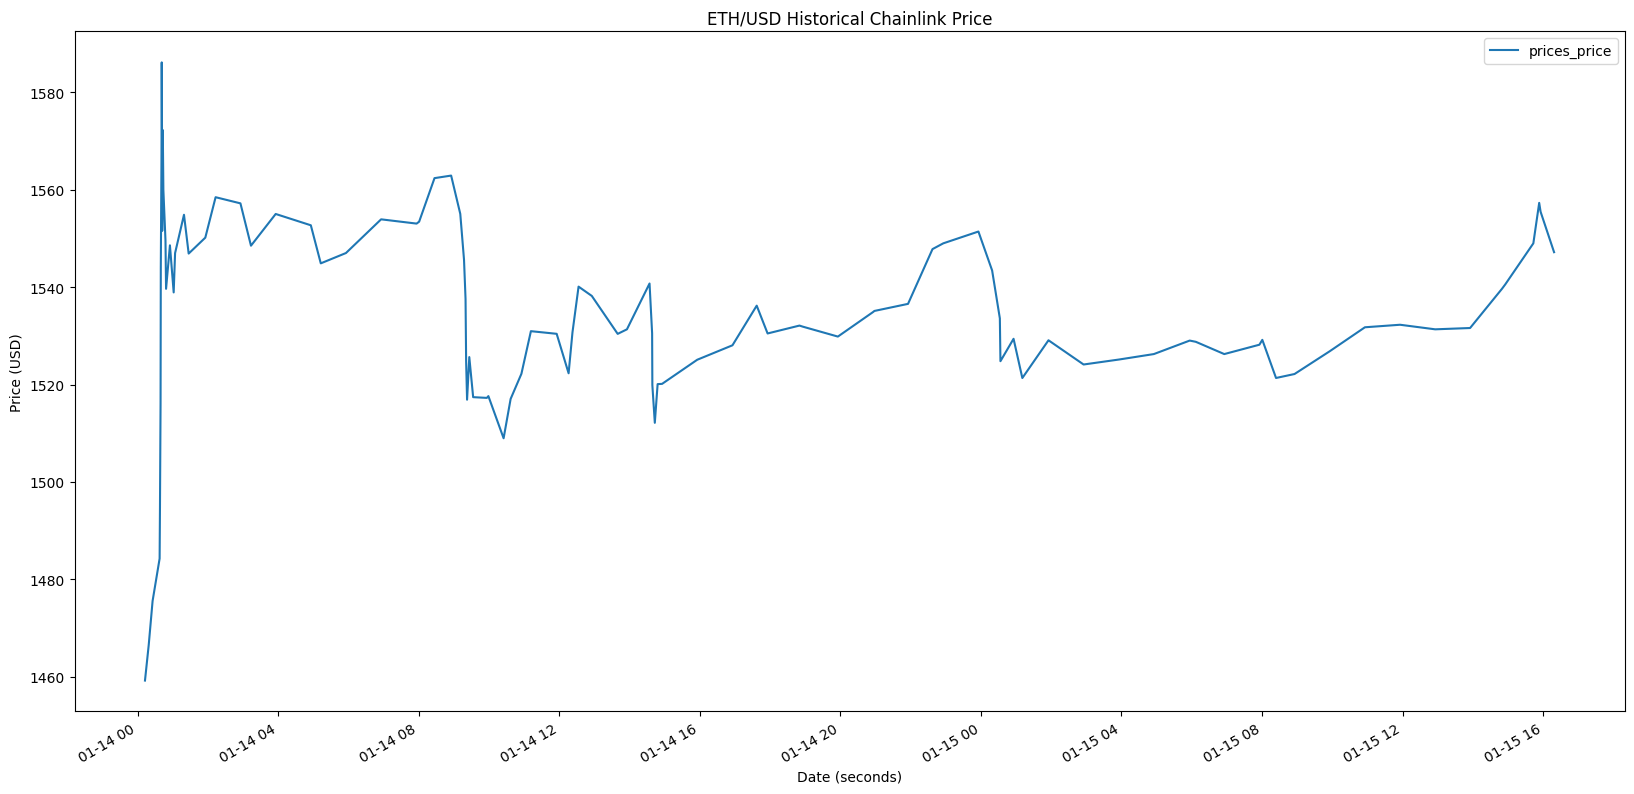

In [22]:
eth_df.plot(x='prices_timestamp', y='prices_price', figsize=(20,10))
plt.xlabel('Date (seconds)')
plt.ylabel('Price (USD)')
plt.title('ETH/USD Historical Chainlink Price')
plt.show()